# Import

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import (
    firwin,
    butter, buttord,
    cheby1, cheb1ord,
    cheby2, cheb2ord,
    ellip, ellipord,
    lfilter,
    freqz, sosfreqz,
    resample,
    tf2zpk,
 )
import soundfile as sf
import pandas as pd
from scipy.io import wavfile

# ANSI S1.11 STANDARD

## Paramètres globaux

In [2]:
fs = 12000 # fréquence d'échantillonnage
bands = np.arange(22, 37)   # bande 22 → 36 (car fu < fs/2)
Nbands = len(bands) # nombre de bandes
iir_order = 4  # ordre des filtres IIR
iir_type = 'butterworth'  # type de filtre IIR : 'butterworth', 'chebyshev1', 'chebyshev2', 'elliptic'

## Calcul des fréquences ANSI 1/3 octave

In [3]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

## Design des filtres FIR et IIR

In [4]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl_norm = fl / (fs / 2)
    fu_norm = fu / (fs / 2)

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=128,               # (ordre 127)
        cutoff=[fl, fu],           # bande passante en Hz
        pass_zero=False,
        fs=fs
    )
    filters_FIR.append(taps)

    # IIR selon le type choisi
    if iir_type == 'butterworth':
        b, a = butter(N=iir_order, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'chebyshev1':
        b, a = cheby1(N=iir_order, rp=1, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'chebyshev2':
        b, a = cheby2(N=iir_order, rs=60, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'elliptic':
        b, a = ellip(N=iir_order, rp=1, rs=60, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    filters_IIR.append((b, a))

print("Les 16 filtres 1/3-octave ont été générés avec succès !")

Les 16 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

## Plot des réponses fréquentielles (FIR)

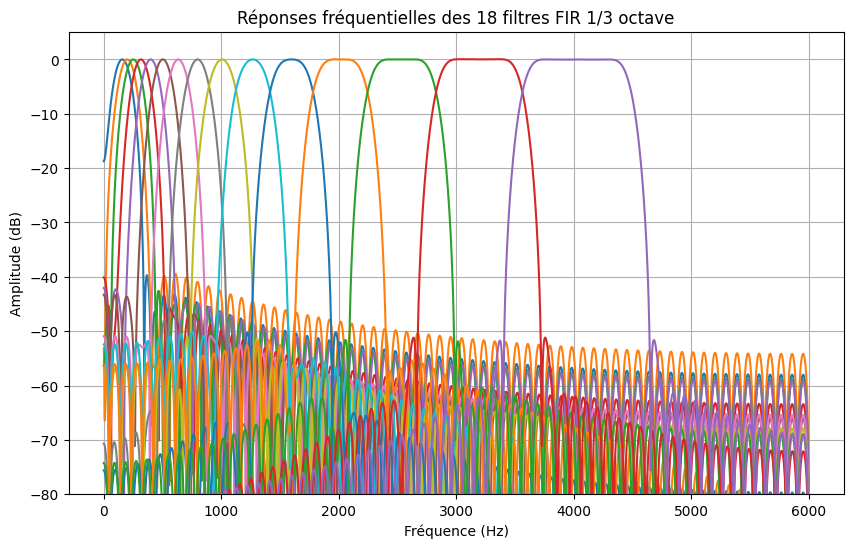

In [5]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(taps, [1], worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Plot des réponses fréquentielles (IIR)

/tmp/ipykernel_27257/729445778.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20*np.log10(np.abs(h)))


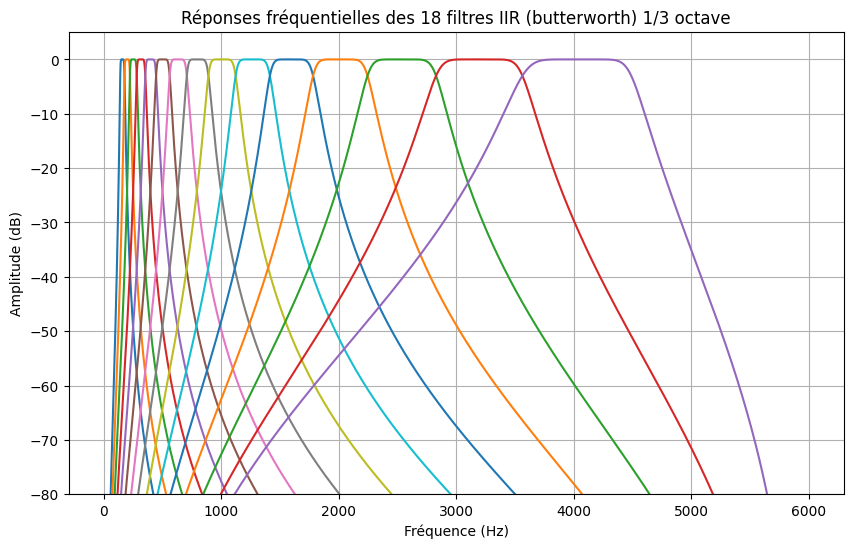

In [6]:
plt.figure(figsize=(10,6))
for b, a in filters_IIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(b, a, worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title(f"Réponses fréquentielles des 18 filtres IIR ({iir_type}) 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Test sur audio

In [7]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for b, a in filters_IIR:
    filtered_sig = lfilter(b, a, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 44100 Hz à 12000 Hz
Filtrage terminé !


## Sauvegarde des bandes filtrées

In [8]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Toutes les bandes filtrées ont été sauvegardées !


## Plot de comparaison FIR vs IIR

In [9]:
def plot_ansi_mask(ax, fl, fu, fs, ripple=1, att1=18, att2=50):
    """
    Trace une enveloppe ANSI S1.11 classe 2 (upper mask + lower mask).
    
    Paramètres :
        fl : fréquence basse de la bande passante (Hz)
        fu : fréquence haute de la bande passante (Hz)
        fs : fréquence d'échantillonnage (Hz)
        ripple : ripple max en bande passante (dB)
        att1 : atténuation min zone 1 (transition)    typiquement >= 18 dB
        att2 : atténuation min zone 2 (deep stopband) typiquement >= 50 dB
    """

    # ---- Fréquences clés de la norme ANSI ----
    f1 = fl / (2**(1/6))     # fin transition basse (>=18 dB)
    f2 = fl / (2**(1/3))     # deep stopband basse (>=50 dB)

    f3 = fu * (2**(1/6))     # début transition haute
    f4 = fu * (2**(1/3))     # deep stopband haute

    # Axe fréquentiel dense pour une enveloppe propre
    freqs = np.linspace(1, fs/2, 2000)

    # Construction du masque sup/inf
    upper = np.zeros_like(freqs)
    lower = np.zeros_like(freqs)

    for i, f in enumerate(freqs):

        if fl <= f <= fu:
            # Passband
            upper[i] = +ripple
            lower[i] = -ripple

        elif f1 <= f < fl or fu < f <= f3:
            # Transition zone (>= -att1 dB)
            upper[i] = 0
            lower[i] = -att1

        else:
            # Deep stopband
            upper[i] = 0
            lower[i] = -att2

    # Affichage de l'enveloppe
    ax.fill_between(freqs, lower, upper, color='orange', alpha=0.25,
                    label="ANSI S1.11 class 2 envelope")


In [10]:
def add_ansi_overlay(ax, fl, fu):
    """
    Ajoute sur un graphique matplotlib les zones de référence ANSI S1.11 classe 2
    pour une bande 1/3 d'octave.

    ANSI impose 3 régions :
        Passband (±1 dB)
        Transition band (≥ 18 dB atténuation)
        Deep stopband (≥ 50 dB atténuation)

    Les limites fréquentielles proviennent du standard :
        f1' = fl / 2^(1/3)
        f1  = fl / 2^(1/6)
        fl  = début passband

        fu  = fin passband
        f2  = fu * 2^(1/6)
        f2' = fu * 2^(1/3)

    Args
    ----
        ax : axes matplotlib
        fl : float, fréquence basse (Hz)
        fu : float, fréquence haute (Hz)
    """

    # Points ANSI
    f1p = fl / 2**(1/3)
    f1  = fl / 2**(1/6)

    f2  = fu * 2**(1/6)
    f2p = fu * 2**(1/3)

    # --- Passband ±1 dB ---
    ax.fill_between([fl, fu], -1, 1, color="orange", alpha=0.3,
                    label="Passband (±1 dB)")

    # --- Transition zone >=18 dB ---
    ax.axhline(-18, color='green', linestyle='--', alpha=0.7, label=">= 18 dB")
    ax.axvline(f1,  color='green', linestyle='--', alpha=0.7)
    ax.axvline(f2,  color='green', linestyle='--', alpha=0.7)

    # --- Deep stopband >=50 dB ---
    ax.axhline(-50, color='red', linestyle='--', alpha=0.7, label=">= 50 dB")
    ax.axvline(f1p, color='red', linestyle='--', alpha=0.7)
    ax.axvline(f2p, color='red', linestyle='--', alpha=0.7)

    # Marquer fl, fu
    ax.axvline(fl, color='black', linestyle='--', alpha=0.5)
    ax.axvline(fu, color='black', linestyle=':', alpha=0.5)


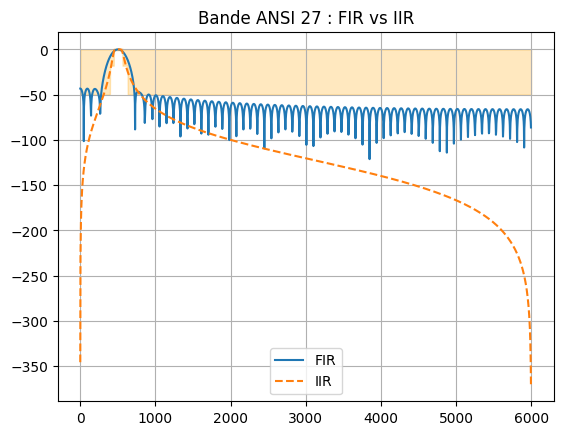

In [11]:
k = 5  # bande 27
fl, f0, fu = ansi_band(bands[k])
taps = filters_FIR[k]
b, a = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = freqz(b, a, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
plot_ansi_mask(plt.gca(), fl, fu, fs)
plt.show()

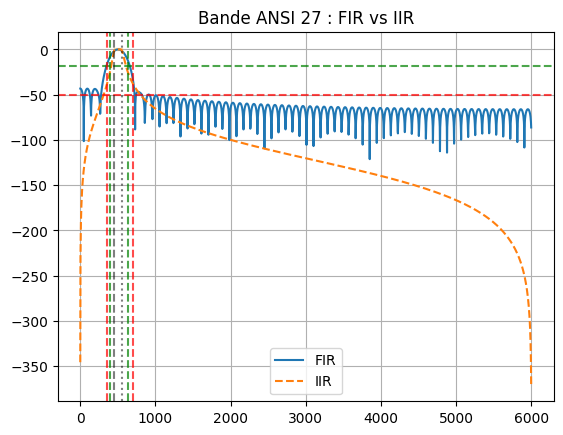

In [12]:

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = freqz(b, a, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
add_ansi_overlay(plt.gca(), fl, fu)
plt.show()

In [13]:
def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


integer_bits nécessaire pour IIR = 7
Arrêt à WL = 31 bits : filtre instable.


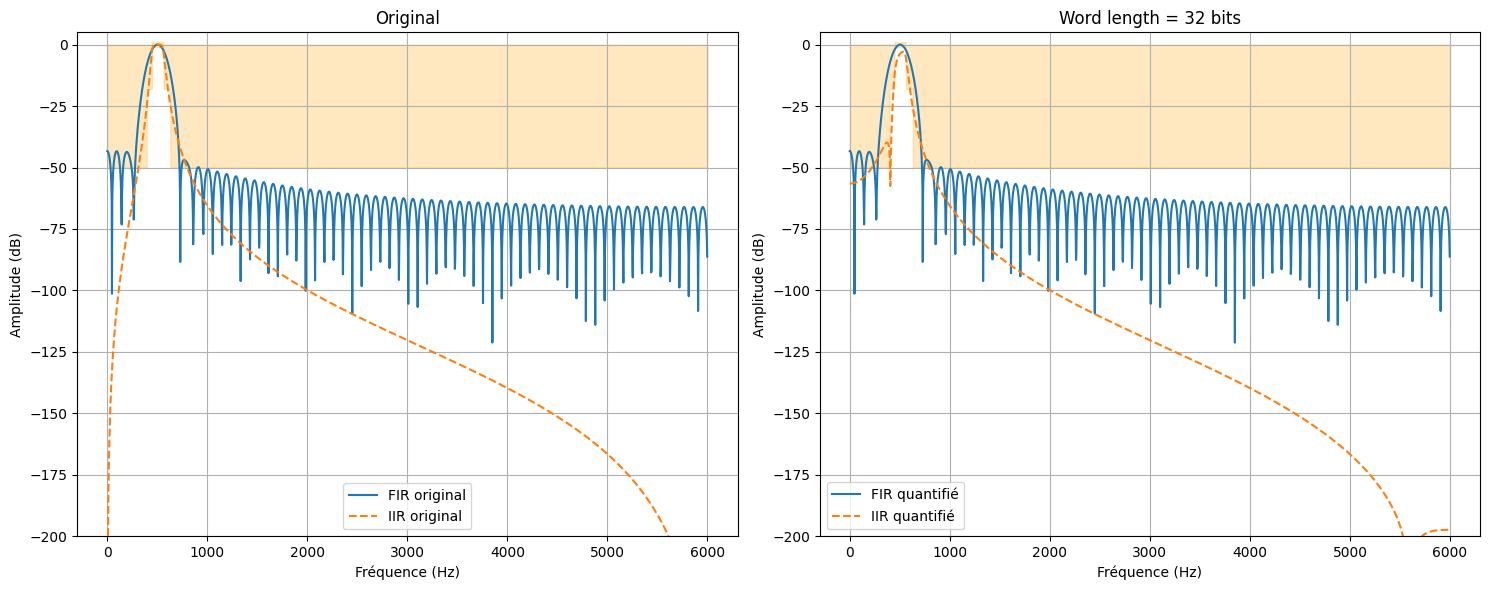

In [14]:
word_lengths = list(range(32, 6, -1))  # 32 à 7 bits

k = 5  # bande 27
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul des fréquences de la bande
fl, f0, fu = ansi_band(bands[k])

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits nécessaire pour IIR = {integer_bits_iir}")

# Calcul des réponses originales
w_orig, h_orig = freqz(taps_original, [1], worN=2048, fs=fs)
w_iir_orig, h_iir_orig = freqz(b_original, a_original, worN=2048, fs=fs)

# Compter le nombre de plots
plot_count = 1  # original
for wl in word_lengths:
    if wl <= integer_bits_iir:
        continue
    taps_q = quantize(taps_original, wl, integer_bits=1)
    b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
    a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
    a_q[0] = 1.0
    p_q = np.roots(a_q)
    if not np.all(np.abs(p_q) < 1):
        break
    plot_count += 1

n_rows = (plot_count + 1) // 2
plt.figure(figsize=(15, 6 * n_rows))

plot_idx = 0

# Plot original
plot_idx += 1
plt.subplot(n_rows, 2, plot_idx)
plt.plot(w_orig, 20*np.log10(np.abs(h_orig)), label='FIR original')
plt.plot(w_iir_orig, 20*np.log10(np.abs(h_iir_orig)), '--', label='IIR original')
plt.title('Original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.ylim([-200, 5])
plt.legend()
plot_ansi_mask(plt.gca(), fl, fu, fs)

for wl in word_lengths:
    if wl <= integer_bits_iir:
        print(f"WL = {wl} bits ignoré (wl <= integer_bits_iir).")
        continue

    taps_q = quantize(taps_original, wl, integer_bits=1)
    b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
    a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
    a_q[0] = 1.0

    # Vérification de stabilité
    p_q = np.roots(a_q)
    if not np.all(np.abs(p_q) < 1):
        print(f"Arrêt à WL = {wl} bits : filtre instable.")
        break

    # Réponses fréquentielles
    w_fir, h_fir = freqz(taps_q, [1], worN=2048, fs=fs)
    w_iir, h_iir = freqz(b_q, a_q, worN=2048, fs=fs)

    # Plot
    plot_idx += 1
    plt.subplot(n_rows, 2, plot_idx)
    plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantifié')
    plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantifié')
    plt.title(f'Word length = {wl} bits')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(True)
    plt.ylim([-200, 5])
    plt.legend()
    plot_ansi_mask(plt.gca(), fl, fu, fs)

plt.tight_layout()
plt.show()

Max coeff IIR = 59.75505178789576
integer_bits IIR = 7


/tmp/ipykernel_27257/3097524963.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label=f'IIR (quantifié {wl} bits)')


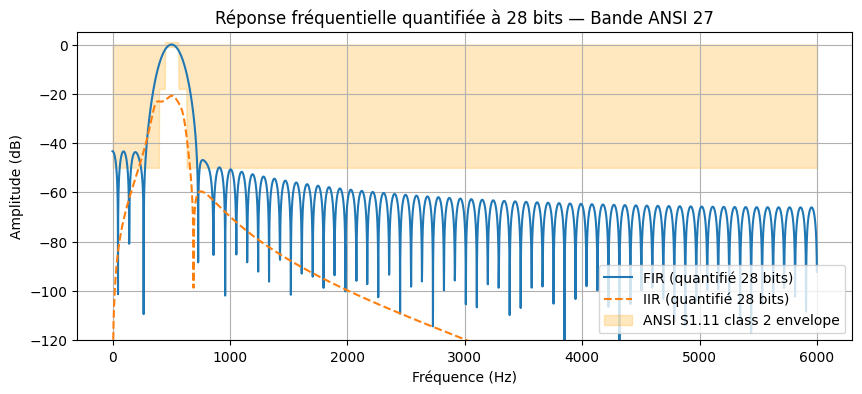

In [15]:
# Choix de la bande
k = 5   # bande ANSI 27 = centre environ 1000 Hz

# Coefficients originaux
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print("Max coeff IIR =", max_iir_coeff)
print("integer_bits IIR =", integer_bits_iir)


# Quantification à 28 bits
wl = 28

# FIR quantifié (1 bit entier → Q1.(wl-1))
taps_q = quantize(taps_original, wl, integer_bits=1)

# IIR quantifié :
#  - integer_bits_iir bits pour la partie entière (sûr)
#  - a0 doit rester EXACTEMENT à 1.0
b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0     # normalisation indispensable

# Réponses fréquentielles
w_fir, h_fir = freqz(taps_q, [1], worN=4096, fs=fs)
w_iir, h_iir = freqz(b_q, a_q, worN=4096, fs=fs)

# AFFICHAGE
plt.figure(figsize=(10, 4))
plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label=f'FIR (quantifié {wl} bits)')
plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label=f'IIR (quantifié {wl} bits)')

# Specification ANSI (pour la bande 27)
fl, f0, fu = ansi_band(bands[k])
plot_ansi_mask(plt.gca(), fl, fu, fs)

plt.title(f"Réponse fréquentielle quantifiée à {wl} bits — Bande ANSI {bands[k]}")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-120, 5])
plt.legend()
plt.show()


## Comparaison avant/après quantification

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


integer_bits pour cette bande IIR = 7
IIR Original – Bande 27:
  Zéros: [-1.00006223+6.22327840e-05j -1.00006223-6.22327840e-05j
 -0.99993777+6.22213721e-05j -0.99993777-6.22213721e-05j
  1.00007827+0.00000000e+00j  1.        +7.82688263e-05j
  1.        -7.82688263e-05j  0.99992173+0.00000000e+00j]
  Erreur entre racines numérateur et zéros tf2zpk: 0.0
  Pôles: [0.94575533+0.28331944j 0.94575533-0.28331944j 0.96245371+0.23047825j
 0.96245371-0.23047825j 0.93541978+0.26114094j 0.93541978-0.26114094j
 0.94353028+0.2399331j  0.94353028-0.2399331j ]
  Erreur entre racines dénominateur et pôles tf2zpk: 0.0
  Valeurs absolues des zéros : [1.00006223 1.00006223 0.99993777 0.99993777 1.00007827 1.
 1.         0.99992173]
  Valeurs absolues des pôles : [0.98728063 0.98728063 0.98966528 0.98966528 0.97118729 0.97118729
 0.97355908 0.97355908]
  Pôles stables ? : True
IIR Quantifié (27 bits) – Bande 27:
  Zéros: [-1.1924404+0.54787745j -1.1924404-0.54787745j -0.6924404+0.31814796j
 -0.6924404-0.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


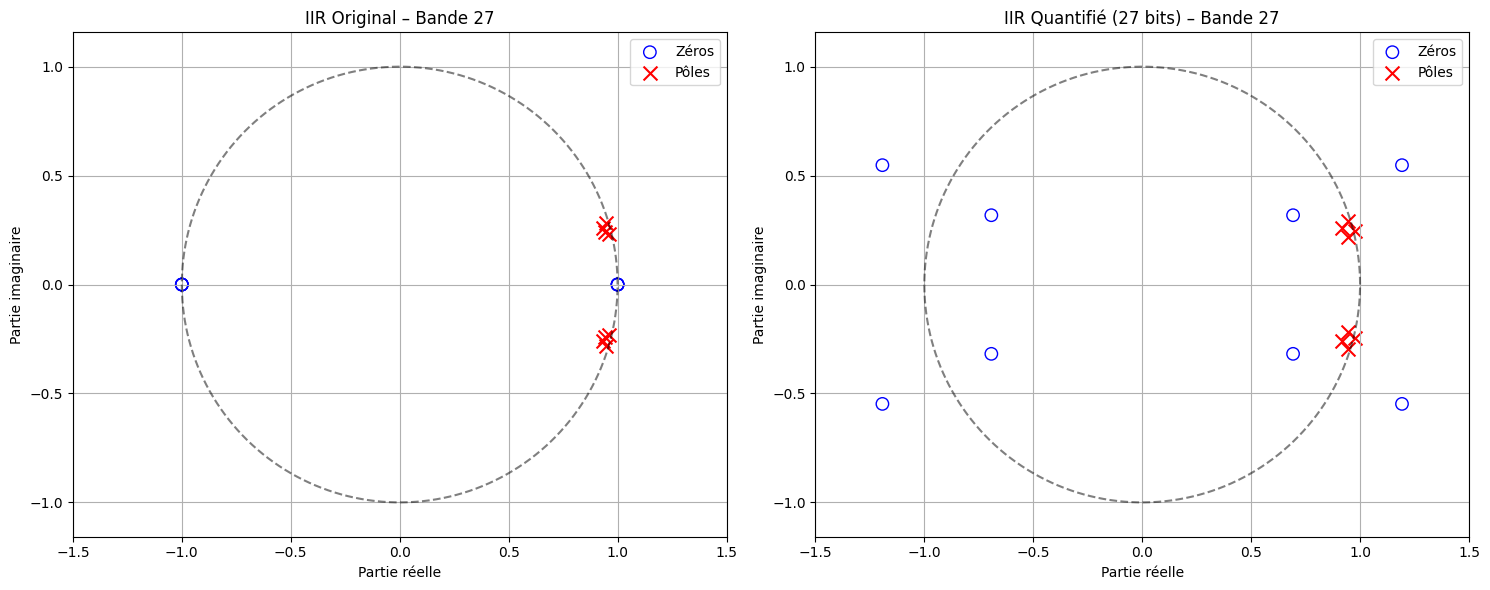

Erreur globale sur les pôles (norme Euclidienne): 0.05038316231804097
Erreur globale sur les zéros (norme Euclidienne): 1.4600594052629206


In [16]:
k = 5  # bande 27
b_orig, a_orig = filters_IIR[k]

# Détection automatique des bits entiers IIR
max_iir_coeff = max(
    np.max(np.abs(b_orig)),
    np.max(np.abs(a_orig))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits pour cette bande IIR = {integer_bits_iir}")

# Quantification
wl = 27
if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} bits < integer_bits nécessaires={integer_bits_iir}")

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0  # normalisation impérative


# Plot pôles / zéros 
def plot_pz(b, a, title, subplot_pos):
    z, p, k = tf2zpk(b, a)

    print(f"{title}:")
    print("  Zéros:", z)
    print("  Erreur entre racines numérateur et zéros tf2zpk:", np.linalg.norm(np.roots(b) - z))
    print("  Pôles:", p)
    print("  Erreur entre racines dénominateur et pôles tf2zpk:", np.linalg.norm(np.roots(a) - p))
    print("  Valeurs absolues des zéros :", np.abs(z))
    print("  Valeurs absolues des pôles :", np.abs(p))
    print("  Pôles stables ? :", np.all(np.abs(p) < 1))
    

    plt.subplot(1, 2, subplot_pos)
    plt.scatter(np.real(z), np.imag(z), marker='o', s=80, facecolors='none', edgecolors='b', label='Zéros')
    plt.scatter(np.real(p), np.imag(p), marker='x', s=100, color='r', label='Pôles')

    # Cercle unité
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)

    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Partie réelle")
    plt.ylabel("Partie imaginaire")
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.legend()
plt.figure(figsize=(15, 6))
plot_pz(b_orig, a_orig, f'IIR Original – Bande {bands[k]}', 1)
plot_pz(b_q, a_q, f'IIR Quantifié ({wl} bits) – Bande {bands[k]}', 2)

plt.tight_layout()
plt.show()

# Calcul de l'erreur globale
z_orig, p_orig, k_orig = tf2zpk(b_orig, a_orig)
z_q, p_q, k_q = tf2zpk(b_q, a_q)
error_poles = np.linalg.norm(p_orig - p_q)
error_zeros = np.linalg.norm(z_orig - z_q)
print("Erreur globale sur les pôles (norme Euclidienne):", error_poles)
print("Erreur globale sur les zéros (norme Euclidienne):", error_zeros)

integer_bits IIR = 7


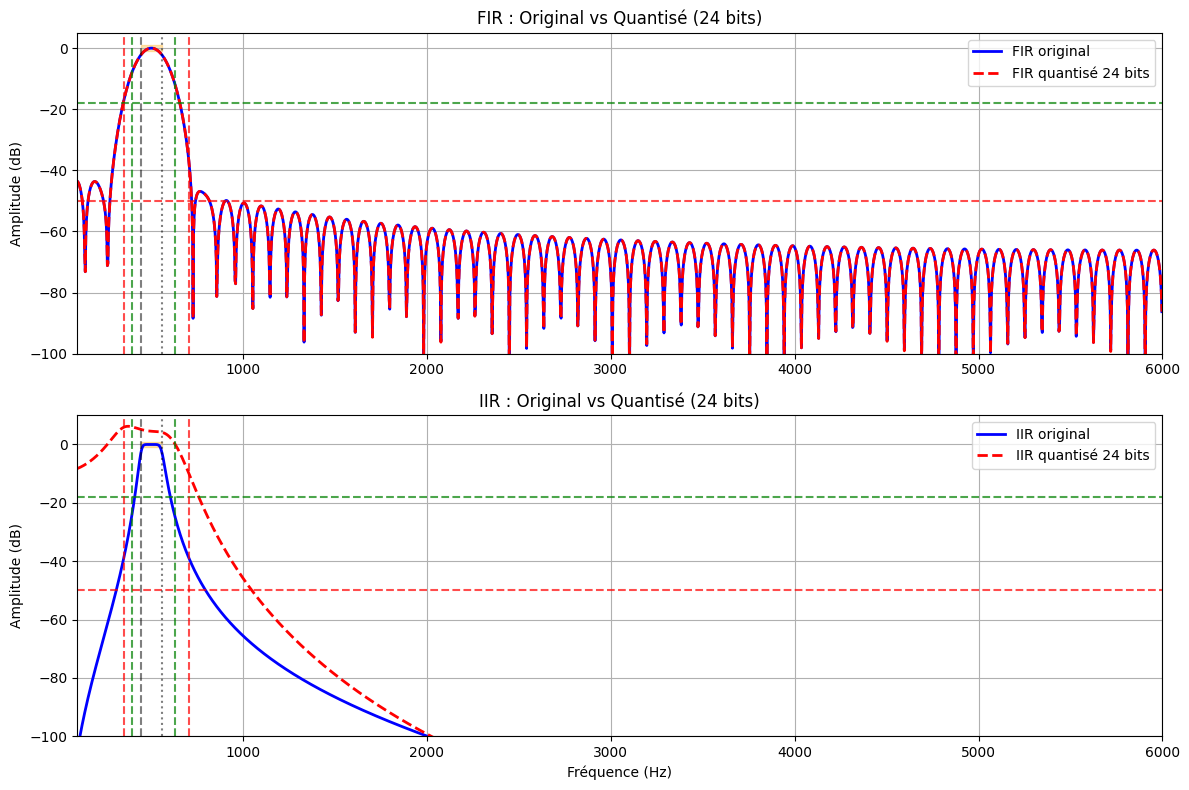

In [17]:
wl = 24
k = 5  # bande 27

taps_orig = filters_FIR[k]
b_orig, a_orig = filters_IIR[k]

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} est trop petit pour ces IIR (besoin de {integer_bits_iir} bits entiers).")

# Quantifications
taps_q = quantize(taps_orig, wl, integer_bits=1)

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0

# Réponses fréquentielles
w_orig_fir, h_orig_fir = freqz(taps_orig, [1], worN=2048, fs=fs)
w_q_fir,   h_q_fir   = freqz(taps_q,       [1], worN=2048, fs=fs)

w_orig_iir, h_orig_iir = freqz(b_orig, a_orig, worN=2048, fs=fs)
w_q_iir,   h_q_iir   = freqz(b_q,   a_q,   worN=2048, fs=fs)

# PLOTS 
plt.figure(figsize=(12, 8))

# FIR
plt.subplot(2, 1, 1)
plt.plot(w_orig_fir, 20*np.log10(np.abs(h_orig_fir)), 'b', linewidth=2, label='FIR original')
plt.plot(w_q_fir,   20*np.log10(np.abs(h_q_fir)),   'r--', linewidth=2, label=f'FIR quantisé {wl} bits')
plt.title(f'FIR : Original vs Quantisé ({wl} bits)')
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 6000])

# IIR
plt.subplot(2, 1, 2)
plt.plot(w_orig_iir, 20*np.log10(np.abs(h_orig_iir)), 'b', linewidth=2, label='IIR original')
plt.plot(w_q_iir,   20*np.log10(np.abs(h_q_iir)),   'r--', linewidth=2, label=f'IIR quantisé {wl} bits')
plt.title(f'IIR : Original vs Quantisé ({wl} bits)')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 10])
plt.legend()
plt.xlim([100, 6000])

# Ajout des overlays ANSI
fl, f0, fu = ansi_band(bands[k])
add_ansi_overlay(plt.subplot(2, 1, 1), fl, fu)
add_ansi_overlay(plt.subplot(2, 1, 2), fl, fu)

plt.tight_layout()
plt.show()

In [18]:
print("\n=== Exemple quantif FIR / IIR pour WL = 24 bits ===")
print("Taps FIR orig :", taps_original[:5])
print("Taps FIR q24   :", quantize(taps_original, 24, integer_bits=1)[:5])

print("\nCoeffs IIR orig :")
print("b:", b_original)
print("a:", a_original)

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

b_q24 = quantize(b_original, 24, integer_bits=integer_bits_iir)
a_q24 = quantize(a_original, 24, integer_bits=integer_bits_iir)
a_q24[0] = 1.0

print("\nCoeffs IIR q24 :")
print("b:", b_q24)
print("a:", a_q24)


=== Exemple quantif FIR / IIR pour WL = 24 bits ===
Taps FIR orig : [-0.0006461  -0.00093321 -0.00118781 -0.00139538 -0.00153802]
Taps FIR q24   : [-0.00064611 -0.00093317 -0.0011878  -0.00139534 -0.00153804]

Coeffs IIR orig :
b: [ 7.80836437e-07  0.00000000e+00 -3.12334575e-06  0.00000000e+00
  4.68501862e-06  0.00000000e+00 -3.12334575e-06  0.00000000e+00
  7.80836437e-07]
a: [  1.          -7.57431819  25.35827081 -48.99832155  59.75505179
 -47.09523145  23.42672554  -6.72562748   0.85347048]
integer_bits IIR = 7

Coeffs IIR q24 :
b: [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  7.62939453e-06  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
a: [  1.          -7.57431793  25.35826874 -48.99832153  59.75505066
 -47.0952301   23.42672729  -6.72562408   0.85346985]


## Verification standard + guess ordre du filtre

In [19]:
def verify_ansi_standard(
    taps_or_b,
    fl,
    fu,
    fs,
    delta_rel=0.05,
    a=None,
    ripple_db=1.0,
    att_db=60.0
):
    """
    Vérification ANSI S1.11 simplifiée et cohérente FPGA.

    Vérifie :
      - ripple passband ±ripple_db
      - atténuation ≥ att_db hors ±1/3 octave
      - stabilité IIR si applicable

    Supporte :
      - FIR : taps_or_b = taps, a=None
      - IIR BA : taps_or_b=b, a=a
      - IIR SOS : taps_or_b = sos (n_sections, 6), a=None
    """

    ripple_pp_max = 2.0 * ripple_db * (1.0 + delta_rel)
    att_min = att_db * (1.0 - delta_rel)

    f_lo = fl / (2 ** (1 / 3))
    f_hi = fu * (2 ** (1 / 3))

    w = np.linspace(0, fs / 2, 8192, endpoint=False)[1:]

    stable_ok = True

    if a is None and isinstance(taps_or_b, np.ndarray) and taps_or_b.ndim == 2:
        w, h = sosfreqz(taps_or_b, worN=w, fs=fs)
        for sec in taps_or_b:
            if np.any(np.abs(np.roots(sec[3:])) >= 1):
                stable_ok = False
                break
    else:
        if a is None:
            w, h = freqz(taps_or_b, worN=w, fs=fs)
        else:
            w, h = freqz(taps_or_b, a, worN=w, fs=fs)
            stable_ok = np.all(np.abs(np.roots(a)) < 1)

    H_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))

    f0 = math.sqrt(fl * fu)
    H_db -= H_db[np.argmin(np.abs(w - f0))]

    passband = (w >= fl) & (w <= fu)
    stopband = (w < f_lo) | (w > f_hi)

    ripple_pp = H_db[passband].max() - H_db[passband].min()
    att_stop = -H_db[stopband].max()

    return {
        "ripple_pp_db": float(ripple_pp),
        "att_stop_db": float(att_stop),
        "stable": bool(stable_ok),
        "valid": bool(
            ripple_pp <= ripple_pp_max
            and att_stop >= att_min
            and stable_ok
        ),
        "spec_ripple_pp_max_db": ripple_pp_max,
        "spec_att_min_db": att_min,
    }


In [20]:
def guess_fir_order(fl, fu, fs, delta_rel=0.05, max_order=200000):
    """
    Recherche dichotomique du plus petit ordre FIR qui respecte ANSI S1.11
    
    Note : Scipy n’a pas d’équivalent de 'filterorder' MATLAB pour FIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        max_order : ordre max à tester (évite boucle infinie)
    
    Returns:
        int : ordre minimal FIR, ou None si pas trouvé dans max_order
    """
    
    # Recherche binaire : on teste des ordres de plus en plus petits/grands
    # pour trouver le plus petit ordre qui satisfait les specs ANSI
    low = 1  # ordre min
    high = max_order  # ordre max
    best = None  # meilleur ordre trouvé (initialement None)
    
    while low <= high:
        mid = (low + high) // 2  # ordre milieu à tester
        
        # Crée un filtre FIR d'ordre mid-1 (numtaps = ordre + 1 car normalement numtaps = ordre + 1)
        taps = firwin(
            numtaps=mid,
            cutoff=[fl/(fs/2), fu/(fs/2)],
            pass_zero=False
        )
        
        # Vérifie si ce filtre respecte ANSI avec la marge delta (relative)
        result = verify_ansi_standard(taps, fl, fu, fs, delta_rel)
        
        if result["valid"]:
            # Filtre valide : on peut essayer plus petit (chercher min)
            best = mid
            high = mid - 1
        else:
            # Pas valide : besoin d'ordre plus élevé
            low = mid + 1
    
    return best

In [21]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type='chebyshev1'):
    """
    Utilise directement la fonction ord appropriée pour obtenir l'ordre minimal IIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        iir_type : type de filtre IIR
    
    Returns:
        int : ordre minimal IIR pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple/atténuation
    # Stopband légèrement rétrécie pour l'atténuation/ripple
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # atténuation max < 1 dB avec marge dans la bande passante
    gstop = 60 * (1 - delta_rel)   # atténuation min > 60 dB avec marge dans la bande d'arrêt

    if iir_type == 'butterworth':
        N, Wn = buttord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev1':
        N, Wn = cheb1ord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev2':
        N, Wn = cheb2ord(wp, ws, gpass, gstop)
    elif iir_type == 'elliptic':
        N, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    return N

In [22]:
fl, f0, fu = ansi_band(27)

fir_order = guess_fir_order(fl, fu, fs, delta_rel=0.05)
iir_order_guessed = guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type=iir_type)

print(f"Ordre FIR trouvé : {fir_order}")
print(f"Ordre IIR {iir_type} trouvé : {iir_order_guessed}")

Ordre FIR trouvé : 35389
Ordre IIR butterworth trouvé : 8


In [23]:
# Tableau des ordres des filtres FIR/IIR pour chaque bande 1/3 octave
# Utilisation des ordres estimés minimal pour respecter ANSI S1.11
iir_types = ['butterworth', 'chebyshev1', 'chebyshev2', 'elliptic']

data = []
for i, band in enumerate(bands):
    fl, f0, fu = ansi_band(band)
    #fir_order_guessed = guess_fir_order(fl, fu, fs, delta_rel=0.05)
    fir_order_guessed = len(filters_FIR) - 1 # juste un truc random pour eviter de calculer car sa met du temps ...
    row = [band, fir_order_guessed]
    for iir_type in iir_types:
        iir_order_guessed = guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type=iir_type)
        row.append(iir_order_guessed)
    
    data.append(row)

columns = ['Bande ANSI', 'Ordre FIR estimé'] + \
    [f'Ordre {iir_type.capitalize()} estimé' for iir_type in iir_types]
df = pd.DataFrame(data, columns=columns)
df

,Bande ANSI,Ordre FIR estimé,Ordre Butterworth estimé,Ordre Chebyshev1 estimé,Ordre Chebyshev2 estimé,Ordre Elliptic estimé
0,22,14,8,5,5,4
1,23,14,8,5,5,4
2,24,14,8,5,5,4
3,25,14,8,5,5,4
4,26,14,8,5,5,4
5,27,14,8,5,5,4
6,28,14,8,5,5,4
7,29,14,8,6,6,4
8,30,14,8,6,6,4
9,31,14,8,6,6,4


In [24]:
wl = 53
delta_rel = 0.05
ripple_db = 1.0
att_db = 60.0

data = []
invalid_filters = []

def check_iir_stability(b, a):
    poles = np.roots(a)
    max_abs_pole = np.max(np.abs(poles))
    return poles, max_abs_pole

for iir_type in iir_types:
    for band in bands:
        fl, f0, fu = ansi_band(band)

        # --- Spécifications de design ---
        wp = np.array([fl, fu]) / (fs / 2)
        ws = np.array([fl / (2 ** (1 / 3)), fu * (2 ** (1 / 3))]) / (fs / 2)

        gpass = ripple_db
        gstop = att_db

        # --- Estimation ordre + design ---
        if iir_type == 'butterworth':
            N, Wn = buttord(wp, ws, gpass, gstop)
            b, a = butter(N, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev1':
            N, Wn = cheb1ord(wp, ws, gpass, gstop)
            b, a = cheby1(N, gpass, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev2':
            N, Wn = cheb2ord(wp, ws, gpass, gstop)
            b, a = cheby2(N, gstop, Wn, btype='bandpass', output='ba')
        elif iir_type == 'elliptic':
            N, Wn = ellipord(wp, ws, gpass, gstop)
            new_N = N+2
            b, a = ellip(new_N, gpass, gstop, Wn, btype='bandpass', output='ba')
        else:
            raise ValueError("Type IIR inconnu")

        effective_order = len(a) - 1

        # --- Bits entiers nécessaires ---
        max_coeff = max(np.max(np.abs(b)), np.max(np.abs(a)))
        ib = max(2, math.ceil(math.log2(max_coeff)) + 1)
        frac_bits = wl - ib
        scale = 2 ** frac_bits

        # --- Quantification ---
        b_q = quantize(b, wl, integer_bits=ib)
        a_q = quantize(a, wl, integer_bits=ib)
        a_q[0] = 1.0
        
        # --- Test de stabilité (pôles du filtre quantifié) ---
        _, max_abs_pole = check_iir_stability(b_q, a_q)
        stable = bool(max_abs_pole < 1.0)


        # --- Vérification ANSI ---
        result = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=delta_rel,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )

        octave = (band - 22) // 3 + 1
        filter_nb = (band - 22) % 3 + 1

        # --- Coefficients b ---
        for i, coeff in enumerate(b_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'b', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),     
                bin(fixed),
                result["valid"]
            ])

        # --- Coefficients a ---
        for i, coeff in enumerate(a_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'a', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),    
                bin(fixed),
                result["valid"],
                stable
            ])

df = pd.DataFrame(
    data,
    columns=[
        'iir_type', 'band', 'octave', 'filter_nb',
        'iir_order_N', 'iir_order_effective',
        'coeff_type', 'coeff_index',
        'integer_bits', 'frac_bits',
        'quantized_value',
        'float_hex',         
        'binary_repr',
        'ansi_valid',
        'stable'
    ]
)

df.to_csv('iir_coefficients_53bits_all_types.csv', index=False)
print("CSV généré : iir_coefficients_53bits_all_types.csv")


CSV généré : iir_coefficients_53bits_all_types.csv


## Légende du CSV des coefficients IIR quantifiés

- **iir_type** : Type de filtre IIR ('butterworth', 'chebyshev1', 'chebyshev2', 'elliptic')
- **band** : Bande ANSI (22 → 36)
- **octave** : Numéro de l'octave (groupes de 3 bandes 1/3 octave, octave 1 = bandes 22-24, etc.)
- **filter_nb** : Numéro du filtre dans l'octave (1, 2 ou 3)
- **iir_order_N** : Ordre prototype retourné par SciPy (N). Pour un bandpass, l'ordre effectif vaut `2*N`.
- **iir_order_effective** : Ordre effectif du filtre bandpass (= 2*N)
- **coeff_type** : Type de coefficient ('b' pour feedforward/numérateur, 'a' pour feedback/dénominateur)
- **coeff_index** : Index du coefficient dans la section (0..2 pour b0..b2 ou a0..a2)
- **integer_bits** : Bits entiers (signé) utilisés pour quantifier cette section
- **frac_bits** : Bits fractionnaires (= wl - integer_bits)
- **quantized_value** : Valeur flottante quantifiée (celle qui sera représentée en fixe)
- **binary_repr** : `bin(fixed)` (entier signé Python, utile pour debug)
- **float_hex** : Représentation hexadécimale “flottante” Python (`float.hex()`)
- **ansi_valid** : Booléen indiquant si le filtre respecte le masque (±1 dB passband, >=18 dB transition, >=60 dB deep stop + stabilité)

In [25]:
def simulate_IIR_DFI(
    u,
    b, a,
    wl_ext, ib_ext,
    wl_out, ib_out
):
    """
    Simule le comportement d'un filtre IIR en forme directe I avec quantification en virgule fixe à la fin des calculs

    Pour chaque échantillon d'entrée (déjà quantifié), la fonction applique les étapes suivantes :
    - Calcul des produits feedforward b_i * u(t-i) (exact)
    - Calcul des produits feedback a_i * ỹ(t-i) (exact)
    - Somme interne des contributions feedforward et feedback (exacte)
    - Quantification interne : ỹ(t)
    - Quantification de sortie : y_out(t)

    Paramètres
    ----------
    u : array-like
        Signal d'entrée quantifié sous forme de tableau de flottants représentant les valeurs quantifiées
    b : array-like
        Coefficients du chemin feedforward [b0, b1, ..., b_M] (déjà quantifiés)
    a : array-like
        Coefficients du chemin feedback [1, a1, ..., a_N] (déjà quantifiés)
        Le premier coefficient a[0] doit être 1 (normalisation unitaire dans la boucle de rétroaction)
    wl_ext, ib_ext : int
        Format Qm.n pour la somme interne ỹ(t)
    wl_out, ib_out : int
        Format Qm.n de la sortie y_out(t)

    Retours
    -------
    y_out : np.ndarray
        Signal de sortie quantifié dans le format wl_out, ib_out
    y_int : np.ndarray
        Valeurs internes ỹ(t) dans le format interne (wl_ext, ib_ext)
    """
    
    u = np.asarray(u, float)
    b = np.asarray(b, float)
    a = np.asarray(a, float)

    nb = len(b)        # nombre de taps feedforward
    na = len(a) - 1    # nombre de coefficients feedback (a1..a_na)

    # Buffer des entrées u(t-i) : u_buf[0] = u(t), u_buf[1] = u(t-1), ...
    u_buf = np.zeros(nb)

    # Buffer des sorties internes ỹ(t-i) : y_buf[0] = ỹ(t-1), y_buf[1] = ỹ(t-2), ...
    y_buf = np.zeros(na)

    y_out = []
    y_int = []

    for n in range(len(u)):
        u_buf[0] = u[n]

        # Décalage du buffer : on pousse les anciennes valeurs vers la droite
        # u_buf[1] = ancien u_buf[0] = u(t-1), etc.
        if nb > 1:
            u_buf[1:] = u_buf[:-1]

        # On calcule les b produits du chemin feedforward (donc ca doit correspondre a un FIR normalement) : Σ b_i * u(t-i)
        acc_ff = 0.0
        for i in range(nb):
            prod_f = b[i] * u_buf[i]
            acc_ff += prod_f

        # On calcule les a produits du chemin feedback (IIR) : Σ a_i * ỹ(t-i)
        # avec a[1] associé à ỹ(t-1), etc.
        acc_fb = 0.0
        for i in range(na):
            prod_f = a[i+1] * y_buf[i]
            acc_fb += prod_f

        # On fait la somme interne y_théorique = Σ(b_i*u) - Σ(a_i*ỹ)
        s = acc_ff - acc_fb

        # Quantification interne : ỹ(t)
        # C'est LA valeur qui tourne dans la récursion.
        # On utilise un format potentiellement plus large (bits de garde) :
        # Q(ib_ext).(wl_ext - ib_ext)
        
        y_tilde = quantize(s, wl_ext, ib_ext)

        # Quantification de sortie : y_out(t)
        # On projette ỹ(t) dans le format externe (DAC / bus)
        # surrement plus "serré" que le format interne
        
        y_out_t = quantize(y_tilde, wl_out, ib_out)

        # Mise à jour du buffer de feedback :
        # y_buf[0] <- ỹ(t), y_buf[1] <- ỹ(t-1), etc.
        if na > 1:
            y_buf[1:] = y_buf[:-1]
        if na > 0:
            y_buf[0] = y_tilde

        # On stocke les valeurs
        y_int.append(y_tilde)
        y_out.append(y_out_t)

    return np.array(y_out), np.array(y_int)

Coeffs Butterworth low-pass ordre 2 :
b = [0.00391613 0.00783225 0.00391613]
a = [ 1.         -1.81534108  0.83100559]


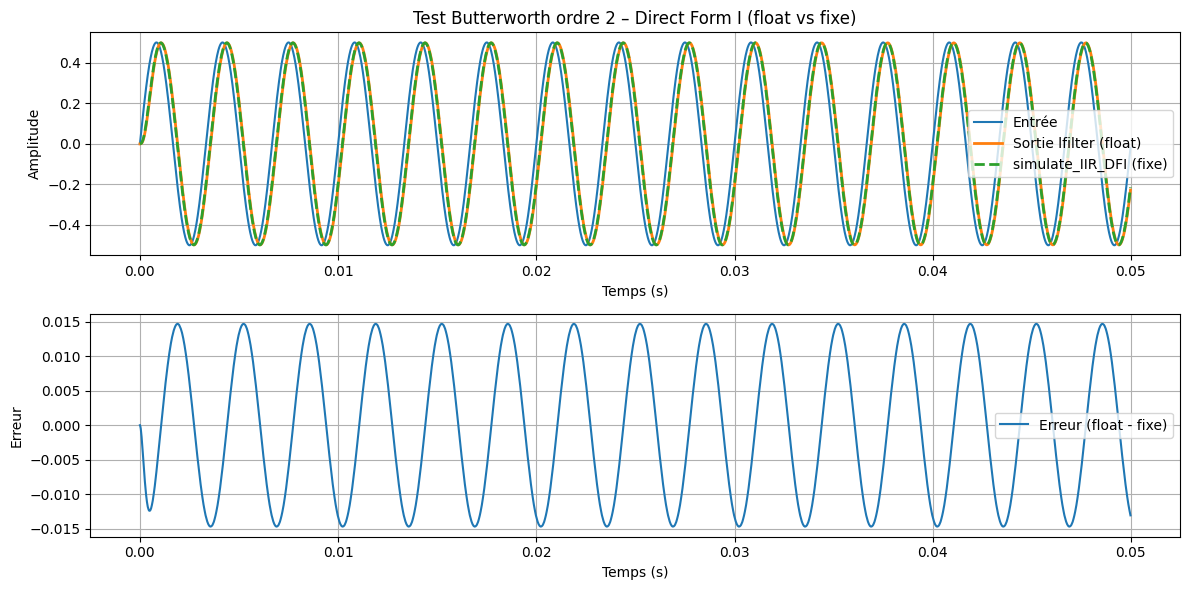

In [26]:
# Filtre de TEST simple (canonique)
fs_test = 48000        # fréquence d'échantillonnage
fc = 1000              # fréquence de coupure low-pass
N  = 2                 # ordre 2

b_lp, a_lp = butter(N, fc/(fs_test/2), btype='low', output='ba')

print("Coeffs Butterworth low-pass ordre 2 :")
print("b =", b_lp)
print("a =", a_lp)

# Signal de test : sinus DANS la bande
duration = 0.05  # 50 ms
t_lp = np.linspace(0, duration, int(fs_test*duration), endpoint=False)
u_lp = 0.5 * np.sin(2*np.pi*300*t_lp)  # 300 Hz, bien en dessous de fc=1000 Hz

# Paramètres de quantification
wl_in,  ib_in  = 16, 1   # Entrée : Q1.15
wl_b,   ib_b   = 20, 2   # Produits b : Q2.18 donc la ca ferais entre [-2, 1] avec scale=1/2^18
wl_a,   ib_a   = 20, 2   # Produits a : Q2.18
wl_ext, ib_ext = 28, 3   # Interne : Q3.25 (bits de garde)
wl_out, ib_out = 16, 1   # Sortie : Q1.15

# Quantification des entrées et coefficients
u_lp_q = quantize(u_lp, wl_in, ib_in)
b_lp_q = quantize(b_lp, wl_b, ib_b)
a_lp_q = quantize(a_lp, wl_a, ib_a)

# Simulation fixe vs flottant
y_lp_fix, y_lp_int = simulate_IIR_DFI(
    u_lp_q, b_lp_q, a_lp_q,
    wl_ext, ib_ext,
    wl_out, ib_out
)

y_lp_ref = lfilter(b_lp, a_lp, u_lp)

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_lp, u_lp, label="Entrée")
plt.plot(t_lp, y_lp_ref, label="Sortie lfilter (float)", linewidth=2)
plt.plot(t_lp, y_lp_fix, '--', label="simulate_IIR_DFI (fixe)", linewidth=2)
plt.title("Test Butterworth ordre 2 – Direct Form I (float vs fixe)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_lp, y_lp_ref - y_lp_fix, label="Erreur (float - fixe)")
plt.xlabel("Temps (s)")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# A-Weighting après la banc de filtres multirate ANSI 1/3-octave

Petit rappel ;')  
Le A-weighting (ou pondération A) est une courbe normalisée appliquée au signal audio pour modéliser la sensibilité réelle de l’oreille humaine en fonction de la fréquence

In [27]:
class FIRFilter:
    """
    Réplique exacte du FIR Int32 utilisé dans le code Julia.
    - h : coefficients entiers du filtre FIR 
    - scaling : nombre de bits de shift à droite (division par 2^scaling)
    - state : registre à décalage interne
    """

    def __init__(self, h, scaling):
        self.h = np.array(h, dtype=np.int64) # int 64 pour éviter les débordements dans les calculs entiers
        self.scaling = scaling  # Nombre de bits pour le shift droit ce qui doit être équivalent à une division par 2^scaling pour ajuster l'échelle de sortie
        self.N = len(h)  # Longueur du filtre utile pour dimensionner le registre d'état
        self.state = np.zeros(self.N, dtype=np.int64)  # Shift register, initialisé à zéro il va donc stocker les échantillons passés

    def evaluate(self, x):
        """
        Filtrage FIR  :
        - on insère le nouvel échantillon en tête du registre
        - on décale tout le registre
        - on calcule la convolution state*h
        - on applique une division par 2^scaling via un shift logique
        """
        x = np.array(x, dtype=np.int64)  # Conversion de l'entrée en int64 pour les calculs entiers fixes
        y = np.zeros_like(x, dtype=np.int64)  # Tableau de sortie de même taille que l'entrée
        state = self.state.copy()  # Copie du registre d'état pour éviter de modifier l'état interne pendant le calcul

        for i, sample in enumerate(x): 
            state[1:] = state[:-1]  # Décalage du registre (poussé vers la droite)
            state[0] = sample 
            y[i] = np.sum(state * self.h) >> self.scaling  # Calcul de la convolution (produit scalaire) puis division par 2^scaling via shift droit

        self.state = state  # Mise à jour de l'état interne pour la prochaine évaluation (mémoire du filtre)
        return y


In [28]:
# Coefficients FIR F39 / F38 / F37 / D (issus de fir.jl)
F39_int = [-1,-6,14,-6,-22,43,-18,-41,66,-22,-36,35,1,19,-87,61,120,-274,149,
           208,-422,217,217,-422,208,149,-274,120,61,-87,19,1,35,-36,-22,66,
           -41,-18,43,-22,-6,14,-6,-1]
scale_F39 = 11

F38_int = [4,0,-13,3,26,-12,-38,26,41,-36,-33,33,13,-4,6,-56,-8,138,-21,-220,
           84,276,-167,-284,242,242,-284,-167,276,84,-220,-21,138,-8,-56,6,
           -4,13,33,-33,-36,41,26,-38,-12,26,3,-13,0,4]
scale_F38 = 11

F37_int = [-1,-3,2,7,2,-11,-11,9,22,3,-27,-21,20,36,-1,-37,-18,20,20,1,2,-4,
           -41,-30,66,100,-45,-174,-34,209,149,-172,-251,67,293,67,-251,
           -172,149,209,-34,-174,-45,100,66,-30,-41,-4,2,1,20,20,-18,-37,-1,
           36,20,-21,-27,3,22,9,-11,-11,2,7,2,-3,-1]
scale_F37 = 11

D_int = [0,21,31,-29,-77,45,171,-59,-375,69,1283,1975,1283,69,-375,-59,
         171,45,-77,-29,31,21,0]
scale_D = 12

In [29]:
class FilterBank:
    """
    Implémentation équivalente à evaluate_filterbank() en Julia.
    On fait ici une implémentation du multirate ANSI :
    - À chaque octave : 3 FIR (F39, F38, F37)
    - Entre octaves : filtre anti-repliement D + décimation par 2
    """

    def __init__(self, F39, F38, F37, D, nb_octaves=6):
        self.F39 = F39
        self.F38 = F38
        self.F37 = F37
        self.D   = D
        self.nb_octaves = nb_octaves

    def downsample(self, x):
        """Décimation par 2 avec padding si nécessaire"""
        if len(x) % 2 == 1:  # Si la longueur est impaire alors on supprime le dernier échantillon pour éviter les erreurs de décimation
            x = x[:-1]
        return x[::2]  # Décimation par 2 : on garde un échantillon sur deux pour réduire la fréquence d'échantillonnage

    def evaluate(self, x):
        """
        Exécute le pipeline multirate complet
        Args:
            x : signal d'entrée (array de int64)
        Returns:
            outputs : liste de 18 signaux filtrés (par bande)
        """
        outputs = []

        # Octave 1 (pas de décimation encore)
        outputs.append(self.F39.evaluate(x))
        outputs.append(self.F38.evaluate(x))
        outputs.append(self.F37.evaluate(x))

        d = self.D.evaluate(x)  # Application du filtre anti-repliement D avant décimation pour éviter les aliasing

        # Octaves suivantes : décimation + filtrage pour chaque octave
        for _ in range(2, self.nb_octaves):  
            d = self.downsample(d)  

            outputs.append(self.F39.evaluate(d))
            outputs.append(self.F38.evaluate(d))
            outputs.append(self.F37.evaluate(d))

            d = self.D.evaluate(d)

        # Dernière décimation + dernière octave
        d = self.downsample(d)
        outputs.append(self.F39.evaluate(d))
        outputs.append(self.F38.evaluate(d))
        outputs.append(self.F37.evaluate(d))

        return outputs


In [30]:
fb = FilterBank(
    FIRFilter(F39_int, scale_F39),
    FIRFilter(F38_int, scale_F38),
    FIRFilter(F37_int, scale_F37),
    FIRFilter(D_int,   scale_D),
    nb_octaves=6
)


In [31]:
def compute_y_square_sum(outputs, nb_octaves=6):
    """
    Calcule les énergies quadratiques pour chaque bande et chaque tranche de temps

    Args:
        outputs (liste) : liste de 18 signaux filtrés (F39, F38, F37 pour chaque octave)
        nb_octaves (entier, facultatif) : nombre d'octaves. La valeur par défaut est 6

    Returns:
        np.ndarray : tableau 2D de forme (18, N) où N est le nombre de segments qui contient les énergies quadratiques moyennes par bande et par segment
    """


    chunk = 2**(nb_octaves - 1)  # Taille initiale des chunks pour l'octave la plus haute (fs / 2^(nb_octaves-1))
    result = []  # Liste pour collecter les tableaux d'énergies pour chaque bande

    idx = 0
    for octave in range(nb_octaves): 
        for _ in range(3):  # Pour chaque bande dans l'octave (F39, F38, F37)
            y = outputs[idx]  # On récupère le signal filtré pour cette bande
            idx += 1 

            n_chunks = len(y) // chunk  # Nombre de chunks dans ce signal (longueur divisée par taille du chunk)
            energies = []  # Liste pour les énergies de cette bande

            for k in range(n_chunks):
                seg = y[k*chunk:(k+1)*chunk]  # On extrait le segment du signal
                energies.append(np.mean(seg.astype(float)**2))  # on calcule l'énergie moyenne (moyenne des carrés) du segment

            result.append(energies)

        chunk //= 2  # On divise la taille du chunk par 2 pour l'octave suivante (car on a la décimation par 2)

    return np.array(result)


In [32]:
fs, x = wavfile.read("test.wav")

# Convertir en mono si stéréo
if x.ndim > 1:
    x = np.mean(x, axis=1)

x = x.astype(np.int64)

outputs = fb.evaluate(x)
energies = compute_y_square_sum(outputs)

np.savetxt("y_square_sum.txt", energies)

Fréquences des bandes (Hz) : [100, 125, 160, 200, 250, 320, 400, 500, 640, 800, 1000, 1280, 1600, 2000, 2560, 3200, 4000, 5120, 6400, 8000, 10240]
Fréquences des bandes utilisées (Hz) : [160, 200, 250, 320, 400, 500, 640, 800, 1000, 1280, 1600, 2000, 2560, 3200, 4000, 5120, 6400, 8000]


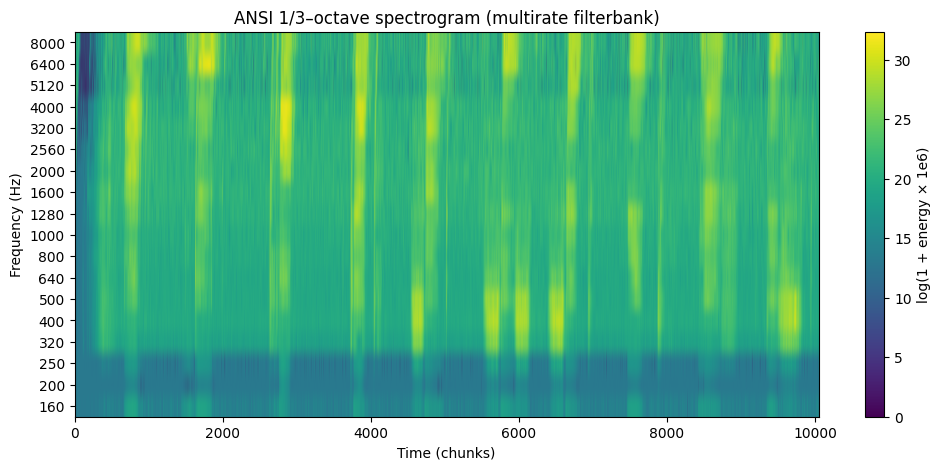

In [33]:
def plot_ansi_spectrogram(energies):

    # fréquences centrales des bandes 1/3 octave selon le standard ANSI S1.11
    freq_labels = [100,125,160]
    for _ in range(1,7):
        freq_labels += list((np.array(freq_labels[-3:])*2).astype(int))
    
    print("Fréquences des bandes (Hz) :", freq_labels)
    freq_labels = freq_labels[2:-1]  # même indexation que le Julia
    print("Fréquences des bandes utilisées (Hz) :", freq_labels)

    plt.figure(figsize=(12,5))
    plt.imshow(np.log1p(1e6*np.abs(energies)), 
               aspect="auto", origin="lower")
    plt.colorbar(label="log(1 + energy × 1e6)")
    plt.yticks(np.arange(18), freq_labels)
    plt.xlabel("Time (chunks)")
    plt.ylabel("Frequency (Hz)")
    plt.title("ANSI 1/3–octave spectrogram (multirate filterbank)")
    plt.show()

plot_ansi_spectrogram(energies)
